In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *
from fastai.data.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
path = Path('training_data/cats')

In [4]:
# Gets a list of all cat breeds so we can search for images.

import requests
from bs4 import BeautifulSoup

url = 'https://en.wikipedia.org/wiki/List_of_cat_breeds'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Find the table with the "Breed" column
table = soup.find('table')

# Find the index of the "Breed" column
header = table.find('tr')
column_names = [col.text for col in header.find_all('th')]
breed_index = column_names.index('Breed\n')

# Extract the "Breed" column values
cat_breeds = []
rows = table.find_all('tr')[1:]  # Exclude the header row
for row in rows:
    cells = row.find_all(['td', 'th'])
    breed_cell = cells[breed_index]
    breed_link = breed_cell.find('a')
    if breed_link:
        cat_breeds.append(breed_link.text)

print(cat_breeds)

['Abyssinian', 'Aegean', 'American Bobtail', 'American Curl', 'American Ringtail', 'American Shorthair', 'American Wirehair', 'Aphrodite Giant', 'Arabian Mau', 'Asian', 'Asian Semi-longhair', 'Australian Mist', 'Balinese', 'Bambino', 'Bengal', 'Birman', 'Bombay', 'Brazilian Shorthair', 'British Longhair', 'British Shorthair', 'Burmese', 'Burmilla', 'California Spangled', 'Chantilly-Tiffany', 'Chartreux', 'Chausie', 'Colorpoint Shorthair', 'Cornish Rex', 'Cymric', 'Cyprus', 'Devon Rex', 'Donskoy', 'Dragon Li', 'Dwelf', 'Egyptian Mau', 'European Shorthair', 'Exotic Shorthair', 'Foldex', 'German Rex', 'Havana Brown', 'Highlander', 'Himalayan', 'Japanese Bobtail', 'Javanese', 'Kanaani', 'Khao Manee', 'Kinkalow', 'Korat', 'Korean Bobtail', 'Kurilian Bobtail', 'Lambkin', 'LaPerm', 'Lykoi', 'Maine Coon', 'Manx', 'Mekong Bobtail', 'Minskin', 'Minuet', 'Munchkin', 'Nebelung', 'Neva Masquerade', 'Norwegian Forest Cat', 'Ocicat', 'Ojos Azules', 'Oregon Rex', 'Oriental Bicolor', 'Oriental Longhair

In [45]:
for c in cat_breeds:
    dest = (path/c)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{c} cat photo', 50))
    download_images(dest, urls=search_images(f'{c} cat standing photo', 50))
    resize_images(path/c, max_size=400, dest=path/c)


Searching for 'Abyssinian cat photo'
Searching for 'Abyssinian cat standing photo'
Searching for 'Aegean cat photo'
Searching for 'Aegean cat standing photo'
Searching for 'American Bobtail cat photo'
Searching for 'American Bobtail cat standing photo'
Searching for 'American Curl cat photo'
Searching for 'American Curl cat standing photo'
Searching for 'American Ringtail cat photo'
Searching for 'American Ringtail cat standing photo'
Searching for 'American Shorthair cat photo'
Searching for 'American Shorthair cat standing photo'
Searching for 'American Wirehair cat photo'
Searching for 'American Wirehair cat standing photo'
Searching for 'Aphrodite Giant cat photo'
Searching for 'Aphrodite Giant cat standing photo'
Searching for 'Arabian Mau cat photo'
Searching for 'Arabian Mau cat standing photo'
Searching for 'Asian cat photo'
Searching for 'Asian cat standing photo'
Searching for 'Asian Semi-longhair cat photo'
Searching for 'Asian Semi-longhair cat standing photo'
Searching for

In [5]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

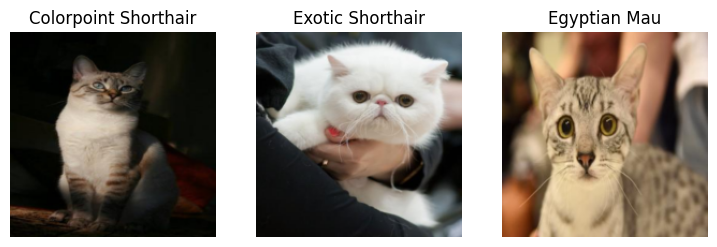

In [6]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=3)

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
%learn.fine_tune(10)

In [9]:
breed,_,probs = learn.predict(PILImage.create('test_trick_sphynx.jpeg'))
print(f"This is a: {breed}.")
p = dict(zip(cat_breeds, probs))
print(f"Probability it's a {breed}: {p[breed]:.4f}")
print(f"Probability it's a Sphynx: {p['Sphynx']:.4f}")
print(f"Probability it's a Dwelf: {p['Dwelf']:.4f}")

This is a: Dwelf.
Probability it's a Dwelf: 0.9999
Probability it's a Sphynx: 0.0000
Probability it's a Dwelf: 0.9999


In [10]:
learn.export("model.pkl")